In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import ann_avg_utils as aau

pint_units, final_units = aau.get_pint_units()

import utils

#%load_ext watermark
#%watermark -d -iv -m -g -h

### Copy data that is shared with time series plotting from aau

In [2]:
global_vars = aau.global_vars()

xp_dir = global_vars['xp_dir']
variables = global_vars['vars']
experiments = global_vars['experiments']
experiment_longnames = global_vars['experiment_longnames']
experiment_dict = global_vars['experiment_dict']
time_slices = global_vars['time_slices']
variables

['photoC_TOT_zint_100m',
 'photoC_diat_zint_100m',
 'photoC_TOT_zint',
 'photoC_diat_zint',
 'POC_FLUX_100m',
 'CaCO3_FLUX_100m',
 'diaz_Nfix',
 'NOx_FLUX',
 'NHy_FLUX',
 'NHx_SURFACE_EMIS',
 'DENITRIF',
 'SedDenitrif',
 'DON_RIV_FLUX',
 'DONr_RIV_FLUX',
 'NO3_RIV_FLUX',
 'ponToSed',
 'FG_CO2',
 'O2',
 'O2_under_thres']

In [3]:
experiments

{'cesm1': ['cesm1_PI',
  'cesm1_PI_esm',
  'cesm1_hist',
  'cesm1_hist_esm',
  'cesm1_RCP85'],
 'cesm2': ['cesm2_PI',
  'cesm2_hist',
  'cesm2_SSP1-2.6',
  'cesm2_SSP2-4.5',
  'cesm2_SSP3-7.0',
  'cesm2_SSP5-8.5']}

In [4]:
cesm2_exp = experiments['cesm2']
cesm2_exp

['cesm2_PI',
 'cesm2_hist',
 'cesm2_SSP1-2.6',
 'cesm2_SSP2-4.5',
 'cesm2_SSP3-7.0',
 'cesm2_SSP5-8.5']

In [5]:
experiment_labels = {e: e.split('_')[1] for e in cesm2_exp}
experiment_labels['cesm2_PI'] = 'Preindustrial'
experiment_labels['cesm2_hist'] = 'Historical'
experiment_labels

{'cesm2_PI': 'Preindustrial',
 'cesm2_hist': 'Historical',
 'cesm2_SSP1-2.6': 'SSP1-2.6',
 'cesm2_SSP2-4.5': 'SSP2-4.5',
 'cesm2_SSP3-7.0': 'SSP3-7.0',
 'cesm2_SSP5-8.5': 'SSP5-8.5'}

In [6]:
variable_labels = dict(
    FG_CO2='Air-sea CO$_2$ flux',
    photoC_TOT_zint_100m='NPP (z > -100m)',
    photoC_TOT_zint='NPP',
    POC_FLUX_100m='POC flux (100 m)',
)
variable_labels

{'FG_CO2': 'Air-sea CO$_2$ flux',
 'photoC_TOT_zint_100m': 'NPP (z > -100m)',
 'photoC_TOT_zint': 'NPP',
 'POC_FLUX_100m': 'POC flux (100 m)'}

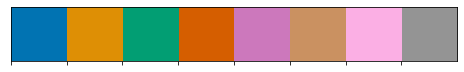

In [7]:
current_palette = sns.color_palette('colorblind', 8)
sns.palplot(current_palette)

exp_colors = {
    'cesm2_PI': current_palette.as_hex()[-1],
    'cesm2_hist': 'k',
    'cesm2_SSP1-2.6': current_palette.as_hex()[0],
    'cesm2_SSP2-4.5': current_palette.as_hex()[1],
    'cesm2_SSP3-7.0': current_palette.as_hex()[2],
    'cesm2_SSP5-8.5': current_palette.as_hex()[3],
}



In [8]:
pretty_units = {
    'PgC/yr': 'Pg C yr$^{-1}$',
    'TgN/yr': 'Tg N yr$^{-1}$',   
}

#### Read output from Make Timeseries.ipynb

Files were written by `xpersist` and are read in using `xr.open_dataset`

Apply units conversion.

In [9]:
dsets, cesm_units = aau.get_ann_means_and_units(xp_dir, variables, experiments, experiment_longnames, pint_units)

for var in variables:
    for exp in cesm2_exp:        
        ds = dsets[var][exp]
        
        var_units = ds[var].attrs['units']
        
        var_data_new_units = (
            ds[var].data * pint_units[var_units]
        ).to(final_units[var]).magnitude
        
        ds[var].values = var_data_new_units
        new_units = final_units[var]
        if new_units in pretty_units:
            new_units = pretty_units[new_units]
        ds[var].attrs['units'] = new_units

dsets.keys()

dict_keys(['photoC_TOT_zint_100m', 'photoC_diat_zint_100m', 'photoC_TOT_zint', 'photoC_diat_zint', 'POC_FLUX_100m', 'CaCO3_FLUX_100m', 'diaz_Nfix', 'NOx_FLUX', 'NHy_FLUX', 'NHx_SURFACE_EMIS', 'DENITRIF', 'SedDenitrif', 'DON_RIV_FLUX', 'DONr_RIV_FLUX', 'NO3_RIV_FLUX', 'ponToSed', 'FG_CO2', 'O2', 'O2_under_thres'])

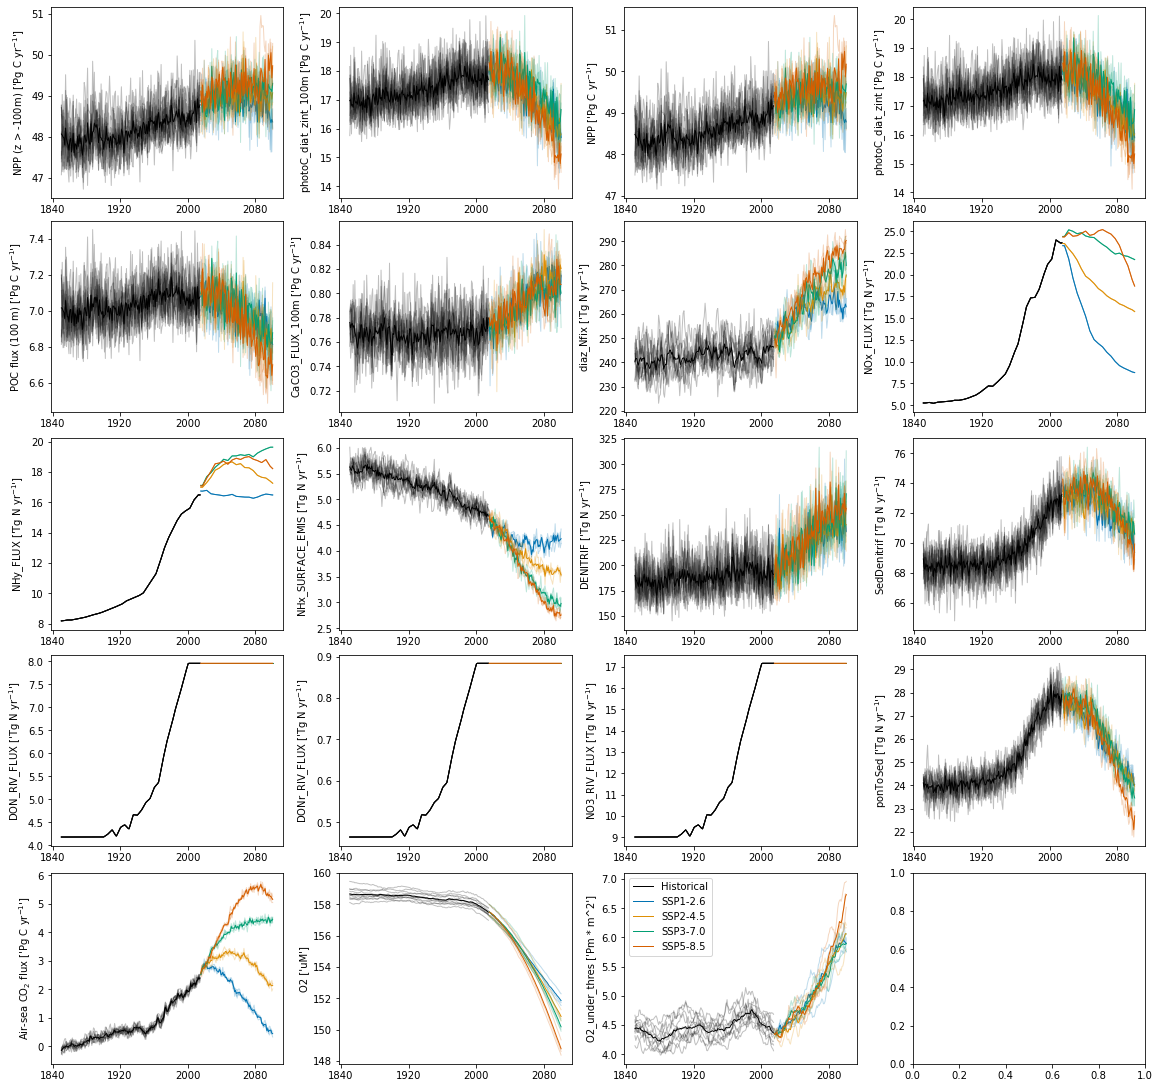

In [10]:
nvar = len(variables)
ncol = min(int(np.sqrt(nvar)), 6)
nrow = int(nvar/ncol) + min(1, nvar%ncol)

fig, axs = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                       constrained_layout=True)

for i, v in enumerate(variables):
    ax = plt.axes(axs.ravel()[i])   
    
    for exp in cesm2_exp:

        if 'PI' in exp:
            continue
            
        ds = dsets[v][exp]
        if v == 'O2_under_thres':
            ds = ds.isel(o2_thres=0)
            
        for member_id in ds.member_id.values:
            plt.plot(ds.time, ds[v].sel(member_id=member_id), '-', alpha=0.25, linewidth=1, color=exp_colors[exp])
       
        plt.plot(ds.time, ds[v].mean('member_id'), '-', linewidth=1, color=exp_colors[exp], label=experiment_labels[exp])

    long_name = v
    if v in variable_labels:
        long_name = variable_labels[v]
        
    plt.ylabel(f'{long_name} {[ds[v].units]}')    
plt.legend()

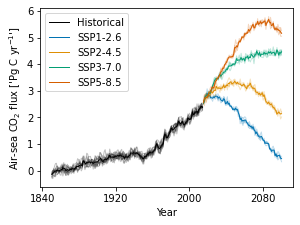

In [11]:
v = 'FG_CO2'

nrow = 1
ncol = 1
fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                       constrained_layout=True)

for exp in cesm2_exp:
    if 'PI' in exp:
        continue
    ds = dsets[v][exp]
    for member_id in ds.member_id.values:
        ax.plot(ds.time, ds[v].sel(member_id=member_id), '-', alpha=0.25, linewidth=1, color=exp_colors[exp])
    ax.plot(ds.time, ds[v].mean('member_id'), '-', linewidth=1, color=exp_colors[exp], label=experiment_labels[exp])

ax.set_ylabel(f'{variable_labels[v]} {[ds[v].units]}')    
ax.set_xlabel('Year')
plt.legend()

utils.savefig(f'global-timeseries-{v}.pdf')

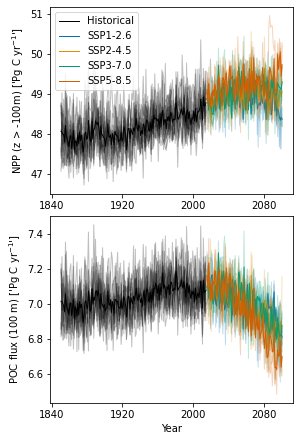

In [12]:
plot_name = 'bio-pump'
varr = np.array([
    ['photoC_TOT_zint_100m'],
    ['POC_FLUX_100m'],    
])

nrow = varr.shape[0]
ncol = varr.shape[1]
fig, axs = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                       constrained_layout=True)

axs = axs.reshape((nrow, ncol))

for i in range(nrow):
    for j in range(ncol):
        v = varr[i, j]
        ax = axs[i, j]
        for exp in cesm2_exp:
            if 'PI' in exp:
                continue
            ds = dsets[v][exp]
            for member_id in ds.member_id.values:
                ax.plot(ds.time, ds[v].sel(member_id=member_id), '-', alpha=0.25, linewidth=1, color=exp_colors[exp])
            ax.plot(ds.time, ds[v].mean('member_id'), '-', linewidth=1, color=exp_colors[exp], label=experiment_labels[exp])

        ax.set_ylabel(f'{variable_labels[v]} {[ds[v].units]}')    
        if i == nrow - 1:
            ax.set_xlabel('Year')

        if i == 0 and j == 0:
            ax.legend()

utils.savefig(f'global-timeseries-{plot_name}.pdf')